In [1]:
from tqdm import tqdm
import numpy as np
import cv2
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from models import *
import warnings

In [2]:
warnings.filterwarnings('ignore')
plt.rcParams["figure.dpi"] = 120
image_dimension = (224, 224)
epochs=100
batch_size = 32
epoch_index = [i for i in range(1, epochs+1)]

#### Check whether GPU is available

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### Load Data, Label for prediction (currently use one dataset (Brain MRI Data2))

In [4]:
labels = {"glioma_tumor":1, "meningioma_tumor":2, "no_tumor":0, "pituitary_tumor":3}
dir_name = "MRI_DATA"
image_list = list()
truth_list = list()

for label, index in labels.items():
    path = os.path.join("Brain_MRI_data2", dir_name, label)
    images = os.listdir(path)
    for image in tqdm(images):
        current_image = cv2.imread(os.path.join(path, image))
        current_image = cv2.resize(current_image, image_dimension)
        image_list.append(current_image)
        truth_list.append(index)

features = np.array(image_list)/255.0 # rescale
labels = tf.keras.utils.to_categorical(truth_list)

100%|██████████| 2658/2658 [00:05<00:00, 475.28it/s]


In [5]:
print("image dimension: {}, label dimension: {}".format(features.shape, labels.shape))

image dimension: (10287, 224, 224, 3), label dimension: (10287, 4)


#### Define model saving function

In [6]:
def save_model(model_name):
    checkpoint = tf.keras.callbacks.ModelCheckpoint(os.path.join("trained_model_weights", model_name),
                                 monitor='val_accuracy',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='max')
    return [checkpoint]

#### Split dataset into train, validation and test set

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=42, shuffle=True)
train_generator = ImageDataGenerator(validation_split=0.25)
test_generator = ImageDataGenerator()

train_df = train_generator.flow(X_train, y_train, batch_size=batch_size, subset="training")
validation_df = train_generator.flow(X_train, y_train, batch_size=batch_size, subset="validation")
test_df = train_generator.flow(X_test, y_test, batch_size=batch_size)

#### Use a simple CNN for training

In [8]:
simple_cnn_path = "simple_cnn.hdf5"
model_simple_cnn = simple_cnn()
model_simple_cnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_simple_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 43264)             0

In [9]:
simple_cnn_history = model_simple_cnn.fit(train_df,
                                          epochs=epochs,
                                          verbose=1,
                                          validation_data=validation_df,
                                          callbacks=save_model(simple_cnn_path))

Epoch 1/100
181/181 [==============================] - 11s 22ms/step - loss: 1.3589 - accuracy: 0.3242 - val_loss: 1.3231 - val_accuracy: 0.4300

Epoch 00001: val_accuracy improved from -inf to 0.42998, saving model to trained_model_weights\simple_cnn.hdf5
Epoch 2/100
181/181 [==============================] - 3s 18ms/step - loss: 1.3229 - accuracy: 0.3482 - val_loss: 1.2958 - val_accuracy: 0.4310

Epoch 00002: val_accuracy improved from 0.42998 to 0.43102, saving model to trained_model_weights\simple_cnn.hdf5
Epoch 3/100
181/181 [==============================] - 3s 19ms/step - loss: 1.2994 - accuracy: 0.3575 - val_loss: 1.2653 - val_accuracy: 0.4481

Epoch 00003: val_accuracy improved from 0.43102 to 0.44813, saving model to trained_model_weights\simple_cnn.hdf5
Epoch 4/100
181/181 [==============================] - 3s 18ms/step - loss: 1.2784 - accuracy: 0.3577 - val_loss: 1.2301 - val_accuracy: 0.4627

Epoch 00004: val_accuracy improved from 0.44813 to 0.46266, saving model to trai

In [10]:
model_simple_cnn.load_weights(os.path.join("trained_model_weights", simple_cnn_path))
model_simple_cnn.evaluate(test_df)

81/81 [==============================] - 1s 13ms/step - loss: 0.1452 - accuracy: 0.9600


[0.1451973021030426, 0.9599533677101135]

Text(0.5, 1.0, 'Simple CNN Model')

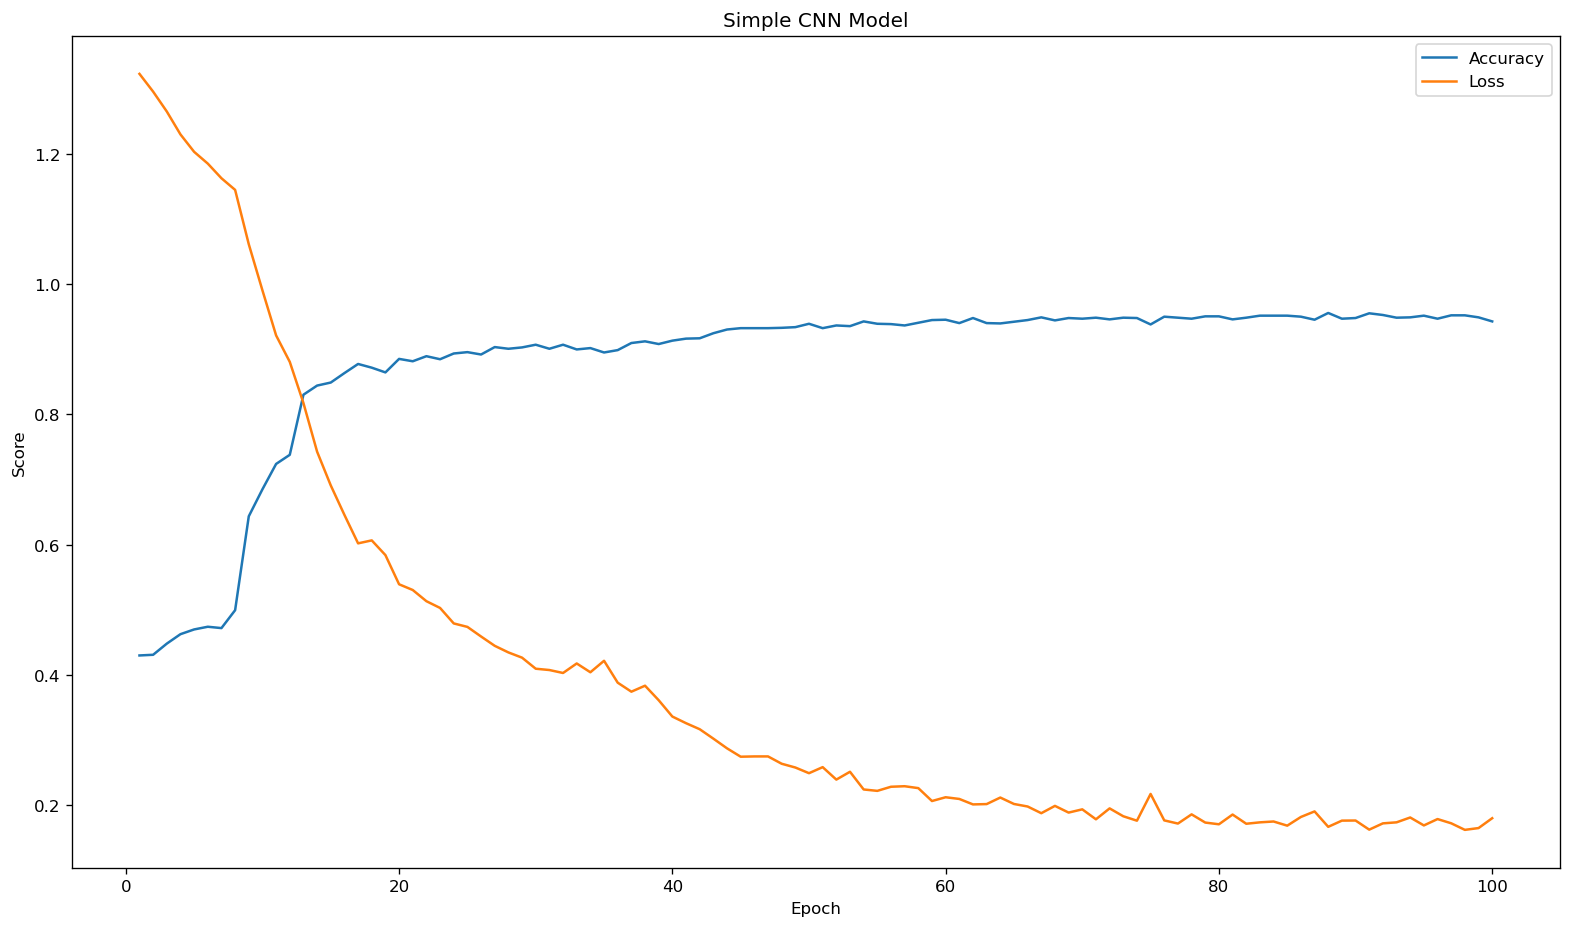

In [11]:
simple_cnn_result = pd.DataFrame({"Accuracy": simple_cnn_history.history["val_accuracy"],
                                  "Loss": simple_cnn_history.history["val_loss"]}, index=epoch_index)
ax_simple_cnn = simple_cnn_result.plot.line(figsize=(16, 9))
ax_simple_cnn.set_xlabel("Epoch")
ax_simple_cnn.set_ylabel("Score")
ax_simple_cnn.set_title("Simple CNN Model")

#### Using Resnet50 for training

In [12]:
model_resnet_path = "resnet50.hdf5"
model_resnet = resnet_50()
model_resnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_resnet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 1000)              25636712  
_________________________________________________________________
input_2 (InputLayer)         multiple                  0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               256256    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 1028      
Total params: 25,893,996
Trainable params: 25,840,876
Non-trainable params: 53,120
_____________________________________

In [13]:
model_resnet_history = model_resnet.fit(train_df,
                 epochs=epochs,
                 verbose=1,
                 validation_data=validation_df,
                 callbacks=save_model(model_resnet_path))

Epoch 1/100
181/181 [==============================] - 33s 147ms/step - loss: 1.3650 - accuracy: 0.5428 - val_loss: 1.3864 - val_accuracy: 0.2376

Epoch 00001: val_accuracy improved from -inf to 0.23755, saving model to trained_model_weights\resnet50.hdf5
Epoch 2/100
181/181 [==============================] - 23s 128ms/step - loss: 1.3256 - accuracy: 0.7538 - val_loss: 1.3852 - val_accuracy: 0.2988

Epoch 00002: val_accuracy improved from 0.23755 to 0.29876, saving model to trained_model_weights\resnet50.hdf5
Epoch 3/100
181/181 [==============================] - 23s 129ms/step - loss: 1.2872 - accuracy: 0.8889 - val_loss: 1.3742 - val_accuracy: 0.3091

Epoch 00003: val_accuracy improved from 0.29876 to 0.30913, saving model to trained_model_weights\resnet50.hdf5
Epoch 4/100
181/181 [==============================] - 23s 128ms/step - loss: 1.2518 - accuracy: 0.9466 - val_loss: 1.3533 - val_accuracy: 0.3952

Epoch 00004: val_accuracy improved from 0.30913 to 0.39523, saving model to tra

KeyboardInterrupt: 

In [ ]:
model_resnet.load_weights(os.path.join("trained_model_weights", model_resnet_path))
model_resnet.evaluate(test_df)

In [ ]:
epoch_index = [i for i in range(1, epochs+1)]
resnet_result = pd.DataFrame({"Accuracy": model_resnet.history.history["val_accuracy"],
                                  "Loss": model_resnet.history.history["val_loss"]}, index=epoch_index)
ax_resnet = resnet_result.plot.line(figsize=(16, 9))
ax_resnet.set_xlabel("Epoch")
ax_resnet.set_ylabel("Score")
ax_resnet.set_title("Resnet50 Model")

#### Using VGG-16

In [ ]:
model_vgg16_path = "vgg16.hdf5"
model_vgg16 = vgg_16()
model_vgg16.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
model_vgg16.summary()

In [ ]:
model_vgg16_history = model_vgg16.fit(train_df,
                                      verbose=1,
                                      epochs=epochs,
                                      validation_data=validation_df,
                                      callbacks=save_model(model_vgg16_path))

In [ ]:
model_vgg16.load_weights(os.path.join("trained_model_weights", model_vgg16_path))
model_vgg16.evaluate(test_df)

In [ ]:
vgg16_result = pd.DataFrame({"Accuracy": model_vgg16_history.history.history["val_accuracy"],
                             "Loss": model_vgg16_history.history.history["val_loss"]}, index=epoch_index)
ax_vgg16 = vgg16_result.plot.line(figsize=(16, 9))
ax_vgg16.set_xlabel("Epoch")
ax_vgg16.set_ylabel("Score")
ax_vgg16.set_title("VGG16 Model")